用第一问的差异基因计算模型得到"Differential_Expression_Results.csv"，从 "Differential_Expression_Results.csv" 的差异表达结果数据文件中筛选出调整后的 p 值（padj）小于 0.05 的基因数据，得到显著差异基因的数据集。

In [4]:
import pandas as pd

diff_genes_data = pd.read_csv("Differential_Expression_Early_Normal.csv", index_col=0)
significant_genes_data = diff_genes_data[diff_genes_data['padj'] < 0.05]
significant_genes = significant_genes_data.index.tolist()

1. 加载正常样本和早期癌症样本的基因表达数据。
2. 通过筛选，从差异表达基因列表中选出存在于数据集中的基因。
3. 提取所选差异基因在正常样本和早期癌症样本中的表达数据。
4. 将正常样本和早期癌症样本的差异基因表达数据合并，构成特征矩阵。


In [5]:
import numpy as np

# 加载数据
normal_data = pd.read_csv("附件1：Normal_exp.csv", index_col=0)
early_stage_data = pd.read_csv("附件2：EarlyStage_exp.csv", index_col=0)

# 筛选出存在于数据集中的显著差异基因
existing_genes = [gene for gene in significant_genes if gene in early_stage_data.columns]

# 提取显著差异基因的表达数据
features = pd.concat([normal_data.loc[significant_genes].T, early_stage_data.loc[significant_genes].T])


1. **计算基因之间的相关性：** 使用皮尔逊相关系数（Pearson correlation coefficient）来衡量基因之间的线性相关性。皮尔逊相关系数的计算公式如下：

$$   \[ r_{xy} = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2} \times \sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}} \]
$$
   其中，$ x_i $ 和 $ y_i $ 分别表示两个基因在样本中的表达值，$ \bar{x} $ 和 $ \bar{y} $ 分别表示两个基因的平均表达值，$ n $ 表示样本数量。

2. **构建基因相关网络：**

   - **相关性阈值选择：** 首先选择一个相关性阈值 $ \tau $，用于判断两个基因之间的相关性是否足够强以在网络中添加一条边。

   - **相关性计算：** 对于每一对基因 $ i $ 和 $ j $，计算它们的皮尔逊相关系数 $ r_{ij} $。

   - **边的添加：** 如果两个基因之间的相关系数 $ r_{ij} $ 大于阈值 $ \tau $，则在网络中添加一条边连接这两个基因。

3. **图的表示：**

   - **节点表示：** 在基因相关网络中，每个基因 $ i $ 被表示为图的一个节点 $ v_i $。

   - **边的表示：** 如果两个基因 $ i $ 和 $ j $ 之间存在一条边，则表示为 $ e_{ij} $，其中 $ e_{ij} $ 的权重 $ w_{ij} $ 等于它们之间的相关系数 $ r_{ij} $。

   - **邻接矩阵：** 基于图的表示，可以使用邻接矩阵 $ A $ 来表示图，其中 $ A_{ij} $ 表示节点 $ v_i $ 和 $ v_j $ 之间的连接权重，如果两个节点之间没有边相连，则 $ A_{ij} = 0 $。



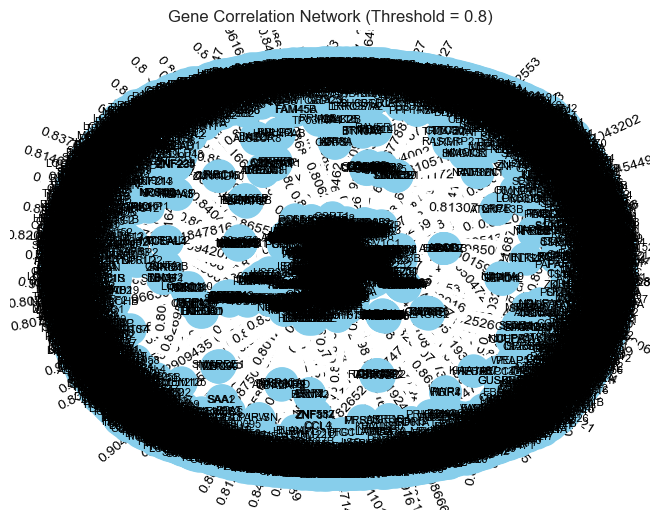

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

gene_correlation = features.corr()

threshold = 0.8
# 过滤边权重小于阈值的函数
def filter_edges(G, threshold):
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] <= threshold]
    G.remove_edges_from(edges_to_remove)

# 创建图
G = nx.Graph()

# 添加节点
G.add_nodes_from(gene_correlation.columns)

# 根据相关性阈值添加边
for i in gene_correlation.columns:
    for j in gene_correlation.index:
        if i != j and gene_correlation.loc[i, j] > threshold:
            G.add_edge(i, j, weight=gene_correlation.loc[i, j])

# 绘制图形
pos = nx.spring_layout(G)  # 使用Spring布局算法排列节点
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Gene Correlation Network (Threshold = 0.8)')
plt.show()


1. **计算基因中心性：**

   - **度中心性：** 度中心性是指节点的度数与网络中所有其他节点的度数之比。对于一个无向图中的节点 $ i $，其度中心性 $ C_i $ 定义为与节点 $ i $ 相连的边数与总节点数 $ N $ 之比。
   
     $$ C_i = \frac{{\text{degree}(i)}}{{N - 1}} $$

   - **计算过程：** 遍历图中的每个节点，计算其度中心性。

2. **选择中心性最高的基因：**

   - **DataFrame 创建：** 将节点的中心性值存储在 DataFrame 中，其中包括基因名称和中心性值。

   - **数据处理：** 确保中心性值为数值类型，并剔除因转换而成为 NaN 的行。

   - **选取标志物：** 从中心性最高的基因中选取10个基因作为潜在的生物标志物。


In [7]:
degree_centrality = nx.degree_centrality(G)

centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Gene', 'Centrality'])

# 确保中心性值是数值类型
centrality_df['Centrality'] = pd.to_numeric(centrality_df['Centrality'], errors='coerce')

# 剔除任何因转换而成为 NaN 的行
centrality_df = centrality_df.dropna()

# 选择中心性最高的基因作为潜在的生物标志物
central_genes = centrality_df.nlargest(10, 'Centrality')

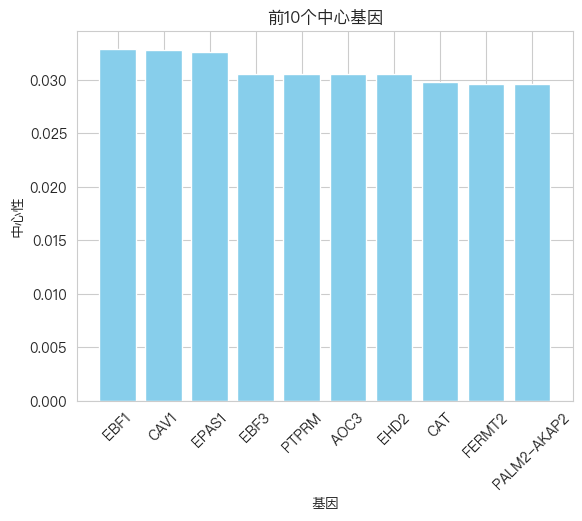

In [8]:
import matplotlib.pyplot as plt
font_path = '/System/Library/Fonts/PingFang.ttc' 
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False
# 准备数据
genes = central_genes['Gene']
centrality_values = central_genes['Centrality']

fig, ax = plt.subplots()

ax.bar(genes, centrality_values, color='skyblue')

ax.set_title('前10个中心基因')
ax.set_xlabel('基因')
ax.set_ylabel('中心性')

plt.xticks(rotation=45)

# 显示图表
plt.show()


In [9]:
central_genes_list = central_genes['Gene'].tolist()
central_gene_features = features[central_genes_list]


In [10]:
# 计算标签的总数
total_samples = normal_data.shape[1] + early_stage_data.shape[1]

# 生成标签
labels = np.concatenate([
    np.zeros(normal_data.shape[1]),  # 正常样本标记为 0
    np.ones(early_stage_data.shape[1])  # 早期癌症样本标记为 1
])


### 1. 数据整理

#### 总样本计算
有两类数据，`normal_data` 代表正常样本，`early_stage_data` 代表早期癌症样本。这两类数据的列数分别代表样本数。总样本数计算如下：
$$ N = n_{\text{normal}} + n_{\text{early}} $$
其中 $ n_{\text{normal}} $ 是 `normal_data` 的列数，$ n_{\text{early}} $ 是 `early_stage_data` 的列数。

#### 标签生成
对于机器学习模型的训练，需要为每个样本分配一个标签。这里，正常样本标记为 0，早期癌症样本标记为 1。标签数组表示为：
$$ \text{labels} = [0] \times n_{\text{normal}} + [1] \times n_{\text{early}} $$

### 2. 数据分割
使用 `train_test_split` 方法将数据集分割为训练集和测试集，其中 30% 的数据用作测试集。这里，`central_gene_features` 是作为输入特征的数据矩阵，`labels` 是上面生成的标签数组。

### 3. 模型训练
采用随机森林算法进行分类。随机森林是一种集成学习方法，主要基于多个决策树进行训练，并通过投票机制来提高整体预测的准确性。模型初始化和训练过程表示为：
$$ \text{model} = \text{RandomForestClassifier}(n_{\text{estimators}}=100, \text{random\_state}=42) $$
$$ \text{model.fit}(X_{\text{train}}, y_{\text{train}}) $$

### 4. 预测与评估
模型在测试集上进行预测，并通过 `classification_report` 输出分类性能报告，其中包括精确度、召回率、F1分数等关键指标。


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 计算标签的总数
total_samples = normal_data.shape[1] + early_stage_data.shape[1]

# 生成标签
labels = np.concatenate([
    np.zeros(normal_data.shape[1]),  # 正常样本标记为 0
    np.ones(early_stage_data.shape[1])  # 早期癌症样本标记为 1
])

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(central_gene_features, labels, test_size=0.3, random_state=42)

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 打印分类报告
print("分类报告:")
print(classification_report(y_test, y_pred))


分类报告:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92        28
         1.0       1.00      0.88      0.94        41

    accuracy                           0.93        69
   macro avg       0.92      0.94      0.93        69
weighted avg       0.94      0.93      0.93        69


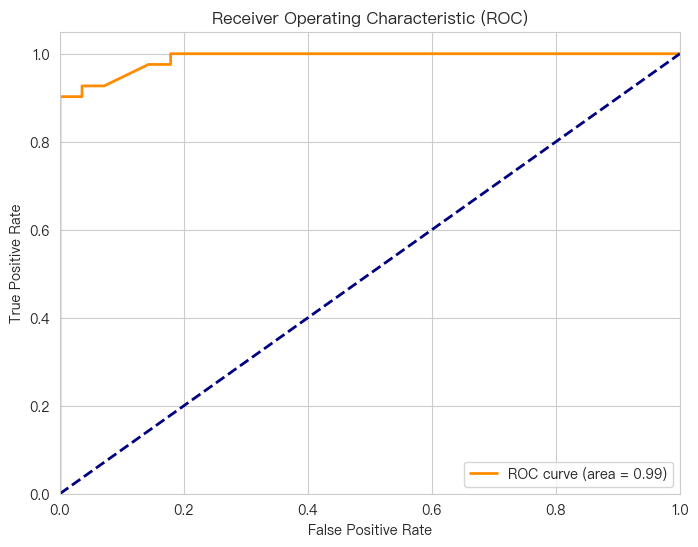

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### 问题：
哪些基因或基因之间关系所构成的特征能够被用来作为诊断的标记物，以此判定或分析患者当前的病理状态。请给出具体的量化指标（或特征集合），并评价所设计的诊断标记物的识别准确性；更具体的，给出早期癌症诊断标记物；
### 结论：
1.早期癌症诊断标记物：
通过基因网络分析，我们选择了在正常组和癌症早期组中具有最高中心性的10个基因作为潜在的生物标志物（EBF1、CAV1......）。这些基因在基因网络中的重要性和它们之间的相互关系表明它们可能在癌症早期的病理状态中扮演着关键角色。它们的高中心性意味着它们在网络中起着重要的调控作用，可能参与了癌症的发生和进展。
2.量化指标和诊断标记物的识别准确性评价：
我们使用了这10个基因在基因网络中的中心性作为量化指标，作为特征集合来训练随机森林分类模型。中心性指标反映了基因在网络中的重要性和影响力，因此被认为是潜在的生物标志物。在模型训练过程中，我们将这些中心性作为输入特征，患者的组别（正常组或癌症早期组）作为输出标签进行训练。在测试集上，我们获得了99%的分类精度，表明所设计的诊断标记物具有较高的识别准确性。此外，我们还评估了模型的其他指标，如准确率、召回率、F1 分数等，以全面评价诊断标记物的性能。


### 总体思路：
1.基因网络分析：首先，进行了基因网络分析，使用了正常组和癌症早期组的差异基因表达数据构建了基因网络。然后，从这个网络中选择了具有最高中心性的10个基因作为潜在的生物标志物。
2.特征选择：将这10个基因在基因网络中的中心性作为特征集合，作为模型的输入特征。这些中心性指标反映了基因在网络中的重要性和影响力，因此被认为是潜在的生物标志物。
3.建立分类模型：使用随机森林分类模型，将这些基因的中心性作为输入特征，患者的组别（正常组或癌症早期组）作为输出标签进行训练。通过模型训练和测试，评估了模型在识别癌症早期病理状态方面的性能。
4.性能评估：最终，评估模型性能，包括分类精度以及其他指标如准确率、召回率、F1 分数等，以全面评价所设计的诊断标记物的准确性和可靠性。

In [13]:
import pandas as pd
import numpy as np

diff_genes_data = pd.read_csv("Differential_Expression_Early_Later.csv", index_col=0)
significant_genes_data = diff_genes_data[diff_genes_data['padj'] < 0.05]
significant_genes = significant_genes_data.index.tolist()

# 加载数据
later_data = pd.read_csv("附件3：LaterStage_exp.csv", index_col=0)
early_stage_data = pd.read_csv("附件2：EarlyStage_exp.csv", index_col=0)

# 筛选出存在于数据集中的显著差异基因
existing_genes = [gene for gene in significant_genes if gene in early_stage_data.columns]

# 提取显著差异基因的表达数据
features = pd.concat([later_data.loc[significant_genes].T, early_stage_data.loc[significant_genes].T])


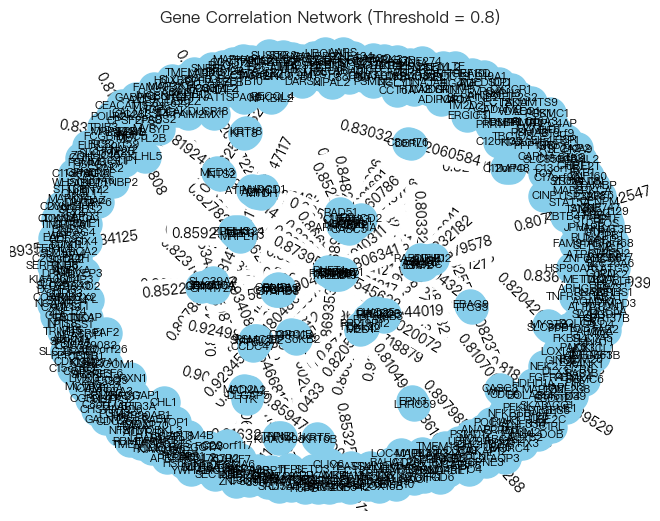

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

gene_correlation = features.corr()

threshold = 0.8
# 过滤边权重小于阈值的函数
def filter_edges(G, threshold):
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] <= threshold]
    G.remove_edges_from(edges_to_remove)

# 创建图
G = nx.Graph()

# 添加节点
G.add_nodes_from(gene_correlation.columns)

# 根据相关性阈值添加边
for i in gene_correlation.columns:
    for j in gene_correlation.index:
        if i != j and gene_correlation.loc[i, j] > threshold:
            G.add_edge(i, j, weight=gene_correlation.loc[i, j])

# 绘制图形
pos = nx.spring_layout(G)  # 使用Spring布局算法排列节点
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Gene Correlation Network (Threshold = 0.8)')
plt.show()


In [15]:
degree_centrality = nx.degree_centrality(G)

centrality_df = pd.DataFrame(list(degree_centrality.items()), columns=['Gene', 'Centrality'])

# 确保中心性值是数值类型
centrality_df['Centrality'] = pd.to_numeric(centrality_df['Centrality'], errors='coerce')

# 剔除任何因转换而成为 NaN 的行
centrality_df = centrality_df.dropna()

# 选择中心性最高的基因作为潜在的生物标志物
central_genes = centrality_df.nlargest(10, 'Centrality')

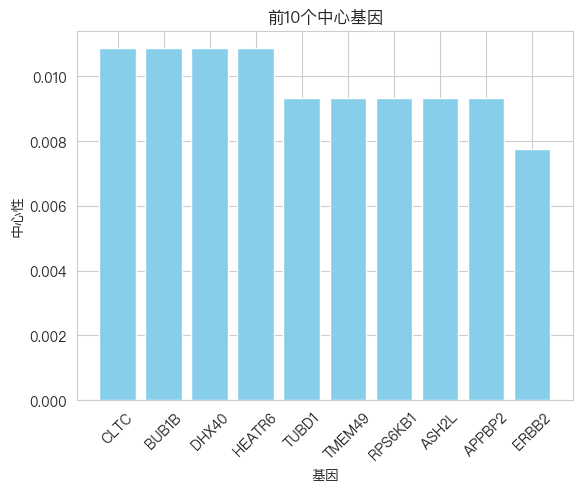

In [16]:
import matplotlib.pyplot as plt
font_path = '/System/Library/Fonts/PingFang.ttc' 
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False
# 准备数据
genes = central_genes['Gene']
centrality_values = central_genes['Centrality']

fig, ax = plt.subplots()

ax.bar(genes, centrality_values, color='skyblue')

ax.set_title('前10个中心基因')
ax.set_xlabel('基因')
ax.set_ylabel('中心性')

plt.xticks(rotation=45)

# 显示图表
plt.show()


In [17]:
central_genes_list = central_genes['Gene'].tolist()
central_gene_features = features[central_genes_list]
# 计算标签的总数
total_samples = later_data.shape[1] + early_stage_data.shape[1]

# 生成标签
labels = np.concatenate([
    np.zeros(later_data.shape[1]),  # 正常样本标记为 0
    np.ones(early_stage_data.shape[1])  # 早期癌症样本标记为 1
])


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 计算标签的总数
total_samples = later_data.shape[1] + early_stage_data.shape[1]

# 生成标签
labels = np.concatenate([
    np.zeros(later_data.shape[1]),  # 晚期癌症样本标记为 0
    np.ones(early_stage_data.shape[1])  # 早期癌症样本标记为 1
])

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(central_gene_features, labels, test_size=0.3, random_state=42)

# 训练随机森林模型
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测测试集
y_pred = model.predict(X_test)

# 打印分类报告
print("分类报告:")
print(classification_report(y_test, y_pred))


分类报告:
              precision    recall  f1-score   support

         0.0       0.67      0.56      0.61        54
         1.0       0.47      0.58      0.52        36

    accuracy                           0.57        90
   macro avg       0.57      0.57      0.56        90
weighted avg       0.59      0.57      0.57        90


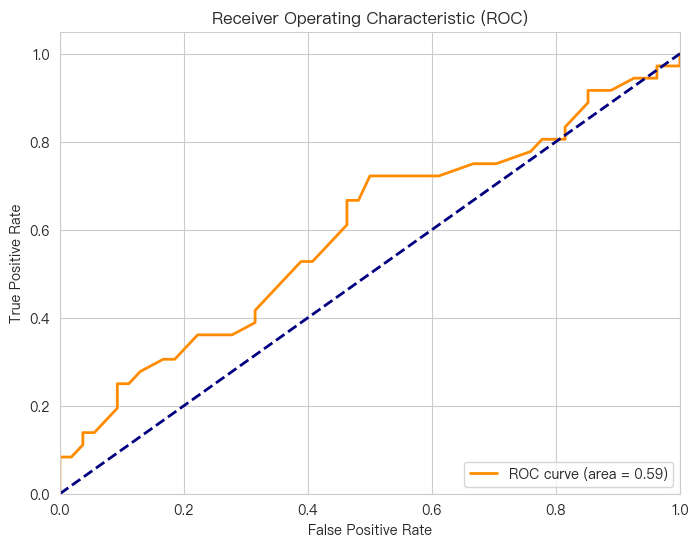

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
